# Importação do csv + lowercasing

Base contendo 154 categorias com 30 instâncias cada. Registros nulos e duplicados foram removidos.


In [148]:
import pandas as pd

df = pd.read_csv('data/produtos_categorias.csv', delimiter=";", quotechar="'", escapechar="\\") # csv to dataframe
df = df.applymap(str.lower) #lowercase

df.columns = ['produto', 'categoria'] # lowercase titles

print(df.head(5))

                                  produto    categoria
0   .always protecao total/normal (todos)  absorventes
1                 .always basico (outros)  absorventes
2                  .a hig_.intimus(todos)  absorventes
3            .a hig_.sempre livre (todos)  absorventes
4  sempre livre slinea s/seca c/abas c/10  absorventes


# Gráfico: distribuição de Produtos x Categoria

In [23]:
# Exibe gráfico de distribuição por categoria

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))
df.groupby('categoria').produto.count().plot.bar(ylim=0)

# Stemming

In [138]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# Pré-processamento

In [149]:
#df['produto'] = df['produto'].str.replace('[^a-zA-Z]',' ') # let only letters
df['produto'] = df['produto'].str.replace('[^a-zA-Z0-9]', ' ') # Permite apenas letras e números
#df['produto'] = df['produto'].str.findall('\w{3,}').str.join(' ') # Mantém apenas palavras com 3+ letras
#df['produto'] = df['produto'].str.replace('\d+', '') # remove only numbers
#df['produto'] = df['produto'].str.replace('[^\w\s]','') # remove simbols except _


# Adiciona categoria como inteiro na coluna categoria_id
df['categoria_id'] = df['categoria'].factorize()[0] 

# Cria dicionário de categorias para uso na matriz de confusão
categoria_id_df = df[['categoria', 'categoria_id']].drop_duplicates().sort_values('categoria_id')
id_para_categoria = dict(categoria_id_df[['categoria_id', 'categoria']].values)

#print(id_para_categoria)
#TOKENIZACAO

#from nltk.tokenize import word_tokenize 

#df['produto_sw'] = df.apply(lambda row: nltk.word_tokenize(row['produto']), axis=1)

#STOPWORDS

#from string import punctuation

#stopwords_pontuacoes = set(stopwords.words('portuguese') + list(punctuation))

#df['produto_sw'] = df['produto'].apply(lambda x: [item for item in x if item not in stopwords_pontuacoes])

#print(df['produto_sw'].head(100))

#STOPWORDS

#print(df.produto.head())

# STEMMING
#from nltk.stem import RSLPStemmer
import nltk

stemmer = nltk.stem.RSLPStemmer()

#df['produto'] = df['produto'].apply(lambda x: [item for item in x if item not in stopwords_pontuacoes])

#print(stemmer.stem("protecao"))
#print(stemmer.stem("normal"))

#df['produto'] = df["produto"].apply(lambda x: [stemmer.stem(y) for y in x])
df['produto'] = df["produto"].apply(lambda row: stem_sentences(row))

df['produto'] = df['produto'].str.findall('\w{2,}').str.join(' ') # Mantém apenas palavras com 3+ letras

#print(df['produto'].head())
print(df.head(5))


                        produto    categoria  categoria_id
0  alway proteca total norm tod  absorventes             0
1              alway basic outr  absorventes             0
2                hig intimu tod  absorventes             0
3            hig sempr livr tod  absorventes             0
4   sempr livr sline sec aba 10  absorventes             0


# TF-IDF + Stopwords

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

stopwords = stopwords.words('portuguese')
#stopwords.append('todos')

#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words=stopwords)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='utf-8', ngram_range=(1, 2))

#print(*stopwords, sep = ", ")
#print(tfidf)

features = tfidf.fit_transform(df.produto).toarray()
labels = df.categoria_id
features.shape

(4620, 6129)

# Comparação entre os modelos

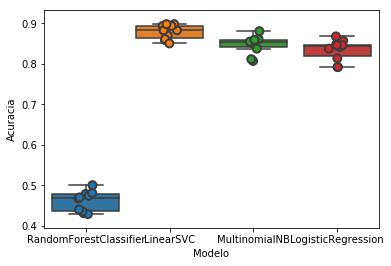

Modelo
LinearSVC                 0.879221
LogisticRegression        0.834416
MultinomialNB             0.847835
RandomForestClassifier    0.460390
Name: Acuracia, dtype: float64

In [156]:
# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Validação
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Gráfico de comparação
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto'),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Modelo', 'fold_idx', 'Acuracia'])

sns.boxplot(x='Modelo', y='Acuracia', data=cv_df)
sns.stripplot(x='Modelo', y='Acuracia', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

cv_df.groupby('Modelo').Acuracia.mean()

# Matriz de confusão

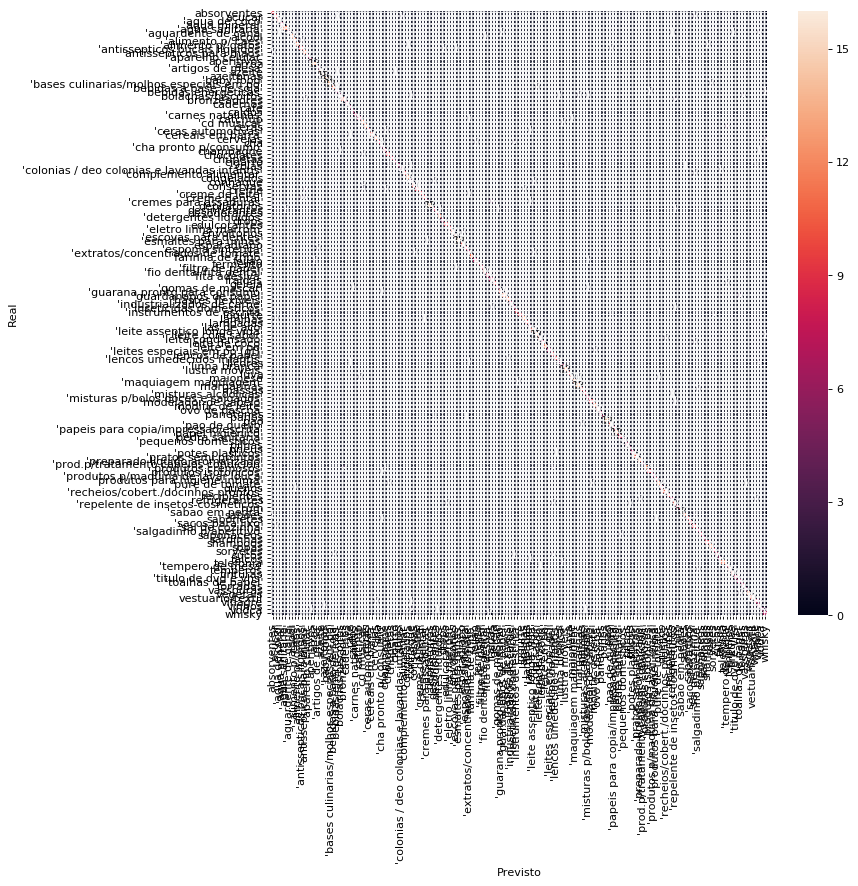

In [73]:
from sklearn.model_selection import train_test_split

model = LinearSVC() # Modelo a ser exibido na matriz 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10), dpi=80)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=categoria_id_df.categoria.values, yticklabels=categoria_id_df.categoria.values)

plt.ylabel('Real')
plt.xlabel('Previsto')
plt.show()

# Visualização das classificações incorretas

In [126]:
from IPython.display import display


for predicted in categoria_id_df.categoria_id: 
    for actual in categoria_id_df.categoria_id:
        if predicted != actual and conf_mat[actual, predicted] >= 1:
            print("'{}' predicted as '{}' : {} examples.".format(id_para_categoria[actual], id_para_categoria[predicted], conf_mat[actual, predicted]))
            #display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['categoria', 'produto']])
            print("")
            


''antissepticos para maos'' predicted as 'absorventes' : 1 examples.

'saboes' predicted as 'absorventes' : 1 examples.

'laminas' predicted as 'acucar' : 1 examples.

''sal de cozinha'' predicted as 'acucar' : 1 examples.

''aguardente de cana'' predicted as ''agua de coco'' : 1 examples.

'desinfetantes' predicted as ''agua sanitaria'' : 1 examples.

'queijos' predicted as ''alimento p/ caes'' : 1 examples.

''alimento p/ caes'' predicted as ''antissepticos bucais liquidos'' : 1 examples.

''creme dental'' predicted as ''antissepticos bucais liquidos'' : 2 examples.

'bronzeadores' predicted as ''antissepticos para maos'' : 1 examples.

'creme' predicted as ''antissepticos para maos'' : 3 examples.

''creme dental'' predicted as ''antissepticos para maos'' : 2 examples.

'vodca' predicted as 'aperitivos' : 1 examples.

'feijao' predicted as 'arroz' : 1 examples.

''esponja sintetica'' predicted as ''artigos de mesa'' : 1 examples.

'vinhos' predicted as 'azeitonas' : 1 examples.

'su